In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from useful_functions import remove_zeros, remove_before, import_file, make_bins, make_equal_bins

In [3]:
loc_b53 = pd.read_excel('2.P04_processed.xlsx')
print(loc_b53)


                   Date  Count
0   2024-06-12 08:01:11    0.0
1   2024-06-12 08:16:11    0.0
2   2024-06-12 08:19:29    3.0
3   2024-06-12 08:24:29   17.0
4   2024-06-12 08:29:29    0.0
..                  ...    ...
158 2024-06-12 22:51:24    0.0
159 2024-06-12 23:06:24    0.0
160 2024-06-12 23:21:25    0.0
161 2024-06-12 23:36:25    0.0
162 2024-06-12 23:51:25    0.0

[163 rows x 2 columns]


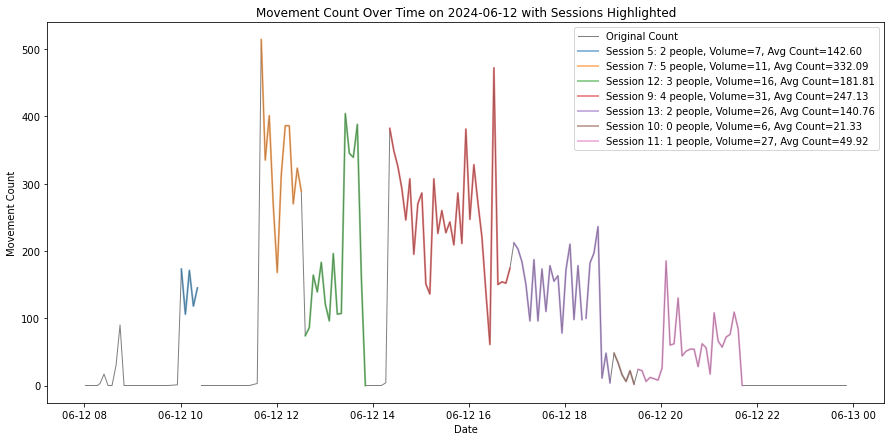

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import numpy as np

# Load the data from CSV (replace 'path_to_your_data.csv' with your actual file path)
data = loc_b53

# Convert the 'Date' column to datetime format
data['Date'] = pd.to_datetime(data['Date'])

# Sort data by date in case it's not sorted
data = data.sort_values('Date')

# Initialize variables
session_id = 0
in_session = False
session_labels = []

# Iterate over the data to identify sessions
for i in range(len(data)):
    if data['Count'].iloc[i] > 0 and not in_session:
        # Start a new session
        in_session = True
        session_id += 1
    
    if in_session:
        session_labels.append(session_id)
    else:
        session_labels.append(0)
    
    if in_session and data['Count'].iloc[i] < 5:
        in_session = False

# Add session labels to the dataframe
data['Session'] = session_labels

# Remove sessions with fewer than 6 data points
session_counts = data['Session'].value_counts()
valid_sessions = session_counts[session_counts >= 6].index
data.loc[~data['Session'].isin(valid_sessions), 'Session'] = 0

# Function to remove outliers and calculate average
def remove_outliers_and_calculate_avg(counts):
    q1 = counts.quantile(0.25)
    q3 = counts.quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    filtered_counts = counts[(counts >= lower_bound) & (counts <= upper_bound)]
    return filtered_counts.mean()

# Function to determine the number of people based on the average count
def determine_people(avg_count):
    # Linear relationship: 250 -> 4 people, 125 -> 2 people
    people = avg_count / 62.5  # 250/4 = 62.5
    return round(people)

# Function to split sessions based on changes in rolling average
def split_sessions_based_on_changes(data, window=5, change_threshold=50):
    new_session_id = max(data['Session']) + 1
    for session in data['Session'].unique():
        if session == 0:
            continue
        session_data = data[data['Session'] == session]
        if len(session_data) < 1:
            continue
        
        rolling_avg = session_data['Count'].rolling(window=window, min_periods=2).mean()
        session_data = session_data.copy()
        session_data['Rolling_Avg'] = rolling_avg
        
        prev_avg = rolling_avg.iloc[0]
        for i in range(1, len(session_data)):
            current_avg = rolling_avg.iloc[i]
            if abs(current_avg - prev_avg) > change_threshold:
                data.loc[session_data.index[i:], 'Session'] = new_session_id
                new_session_id += 1
                break
            prev_avg = current_avg

# Split sessions based on changes in rolling average
split_sessions_based_on_changes(data)

# Remove sessions with fewer than 6 data points after splitting
session_counts = data['Session'].value_counts()
valid_sessions = session_counts[session_counts >= 6].index
data.loc[~data['Session'].isin(valid_sessions), 'Session'] = 0

# Function to plot data for a specific day
def plot_day(data, date):
    # Filter data for the specified day
    start_date = datetime.strptime(date, '%Y-%m-%d')
    end_date = start_date + timedelta(days=1)
    day_data = data[(data['Date'] >= start_date) & (data['Date'] < end_date)]
    
    # Plot the original data line
    plt.figure(figsize=(15, 7))
    plt.plot(np.array(day_data['Date']), np.array(day_data['Count']), label='Original Count', color='black', linewidth=1, alpha=0.5)

    # Overlay the session data
    unique_sessions = day_data['Session'].unique()

    for session in unique_sessions[1:]:
        session_data = day_data[day_data['Session'] == session]
        volume = len(session_data)
        avg_count = remove_outliers_and_calculate_avg(session_data['Count'])
        people = determine_people(avg_count)
        label = f'Session {session}: {people} people, Volume={volume}, Avg Count={avg_count:.2f}'
        color = None  # Let matplotlib choose the color

        plt.plot(np.array(session_data['Date']), np.array(session_data['Count']), label=label, linewidth=2, alpha=0.5)

    plt.title(f'Movement Count Over Time on {date} with Sessions Highlighted')
    plt.xlabel('Date')
    plt.ylabel('Movement Count')
    plt.legend()
    plt.show()

# Plot data for a specific day (e.g., '2024-06-12')
plot_day(data, '2024-06-12')


In [1]:
def olivier_functie(file, date):
    # session_stats = filtered_data.groupby('Session')['Count'].agg(
    #     ['sum', 'mean', 'std', 'size']).reset_index()int
    # session_stats.columns = ['Session', 'Total', 'Mean', 'Std', 'Num_Points']
    return img, context